In this notebook we provide three experiments to support the hypothesis that gene expression of a transcription factor is NOT a reliable surrogate of its activity. 

We run different linear models using transcription factor expressions as predictors and target gene's expression as independent variable. We then compare the results from transcription factors that are (not) in the motif. The underlying assumption is that most transcription factors regulating a gene should have their sequence motif in the promoter region of the target. 

## 1. Loading data

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.utils import resample
import statsmodels.api as sm

In [2]:
def translate_geneName_to_geneId(geneName):
        if geneName in set(gene_mapping["gene_name"]) :
            return gene_mapping[gene_mapping["gene_name"] == geneName]["gene_id"].iloc[0]

def get_tf():
    transcription_factors_id = []
    transcription_factors_name = []
    for tf in set(motif.columns):
         if tf in list(gene_mapping.iloc[:, 6]):
            alias = translate_geneName_to_geneId(tf)
            if alias in expression.columns:
                transcription_factors_id.append(alias)
                transcription_factors_name.append(tf)
    return transcription_factors_id, transcription_factors_name

def get_regulators_id(geneId):
    """
    Extract TF whose sequence motif is present in the promoter of the provided gene
    """
    if geneId in regulators_id.keys() :
        return regulators_id[geneId]
    tfs = motif.loc[geneId, :]
    regulators_names = list(tfs[tfs != 0].keys())
    res = []
    for tf in regulators_names:
        if tf in set(gene_mapping['gene_name']):
            res.append(translate_geneName_to_geneId(tf))
    regulators_id[geneId] = res
    return res

In [4]:
expression = pd.read_csv("data/luad/raw/female_luad.csv", sep = ',', index_col = 0).T
motif = pd.read_csv("data/luad/motif_female.txt", sep = ',', index_col = 0)
gene_mapping = pd.read_csv('data/luad/raw/gen_v26_mapping.csv', sep=',', index_col=[0])
gene_mapping["gene_id"] = gene_mapping["gene_id"].apply(lambda x: x.split('.', 1)[0])
transcription_factors_id, transcription_factors_name = get_tf()
regulators_id = {}
regulators_name = {}

## 2. Number of (non)motif regulators

In [10]:
def get_pen(X, Y) :
    lambdas = list(np.linspace(1, 0.1, 5))
    kf = KFold(n_splits = 5)
    min_error = float('inf')
    best_lambda = 0

    for l in lambdas :
        error = 0
        for train, test in kf.split(X):
            weights = sm.OLS(Y.iloc[train], X.iloc[train]).fit_regularized(method = 'elastic_net', alpha = l, L1_wt = 1, refit = False).params
            error += mean_squared_error(Y.iloc[test], X.iloc[test].dot(weights))
        if error < min_error : 
            best_lambda = l
    return best_lambda

In [13]:
X = expression.T.loc[transcription_factors_id].T
stats = [0, 0, 0]
cnt = 0
for gene in list(set(expression.columns) - set(transcription_factors_id)) : 
    taken = 0
    total = 0
    Y = expression.T.loc[gene].T
    best_lambda = get_pen(X, Y)
    weights = sm.OLS(Y, X).fit_regularized(method = 'elastic_net', alpha = best_lambda, L1_wt = 1, refit = False).params
    for i, w in enumerate(weights[weights != 0]) :
        if X.columns[i] in get_regulators_id(gene) : 
            taken += 1
        total += 1
    stats[0] += taken
    stats[1] += len(get_regulators_id(gene))
    stats[2] += total
    if cnt % 10 == 0 :
        print(cnt)
    cnt += 1
    if cnt > 50 :
        break

stats[0] /= 50
stats[1] /= 50
stats[2] /= 50
print(stats)

0
10
20
30
40
50
[9.56, 83.26, 71.06]


## 3. Feature relevance

In [23]:
gene = random.sample(list(set(expression.columns) - set(transcription_factors_id)), 1)[0]
X = expression[list(transcription_factors_id)]
Y = expression[gene]
count = dict.fromkeys(transcription_factors_id,0)
B = 100
for i in range(B) :
    X1, Y1 = resample(X, Y, replace = True, n_samples = len(Y))
    best_lambda = get_pen(X1, Y1)
    weights = sm.OLS(Y1, X1).fit_regularized(method = 'elastic_net', alpha = best_lambda, L1_wt = 1, refit = False).params
    for j, w in enumerate(weights) :
        if w != 0 :
            count[transcription_factors_id[j]] += 1

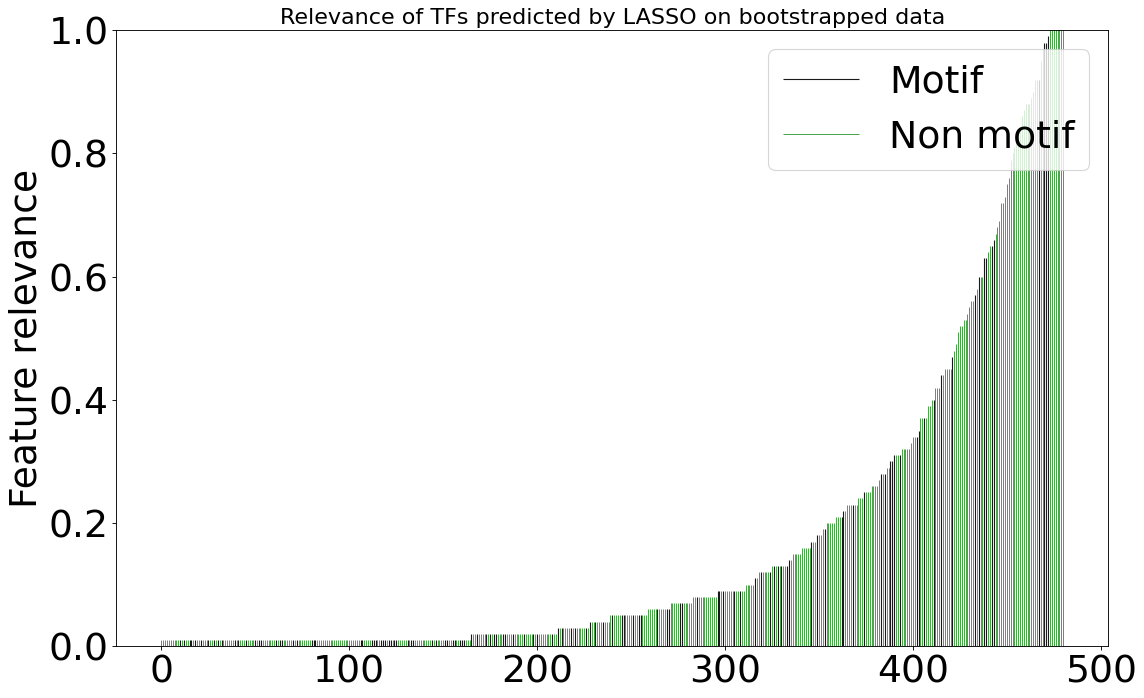

In [29]:
motif_rank = []
motif_val = []
other_rank = []
other_val = []
idx = 0
for k, v in {k: v for k, v in sorted(count.items(), key=lambda item: item[1])}.items() :
    if k in get_regulators_id(gene) :
        motif_rank.append(idx)
        motif_val.append(v / B + 0.01)
    else :
        other_rank.append(idx)
        other_val.append(v / B + 0.01)
    idx += 1


fig, ax = plt.subplots(figsize=(16,10), facecolor='white', dpi= 80)

ax.vlines(x = motif_rank, 
          ymin = 0, 
          ymax = motif_val, 
          color = 'black',
          linewidth = 1,
          alpha = 0.9,
          label = 'Motif'
         )

ax.vlines(x = other_rank, 
          ymin = 0, 
          ymax = other_val, 
          color = 'green',
          linewidth = .7,
          alpha = 0.9,
          label = 'Non motif'
         )

# Title, Label, Ticks and Ylim
ax.set_title('Relevance of TFs predicted by LASSO on bootstrapped data', fontdict={'size':20})
ax.set(ylabel='Feature relevance', ylim=(0, 1))

plt.legend()
plt.show()

## 4. Comparison of ridge coefficients

0
50
100
150
200
250
300
350
400
450


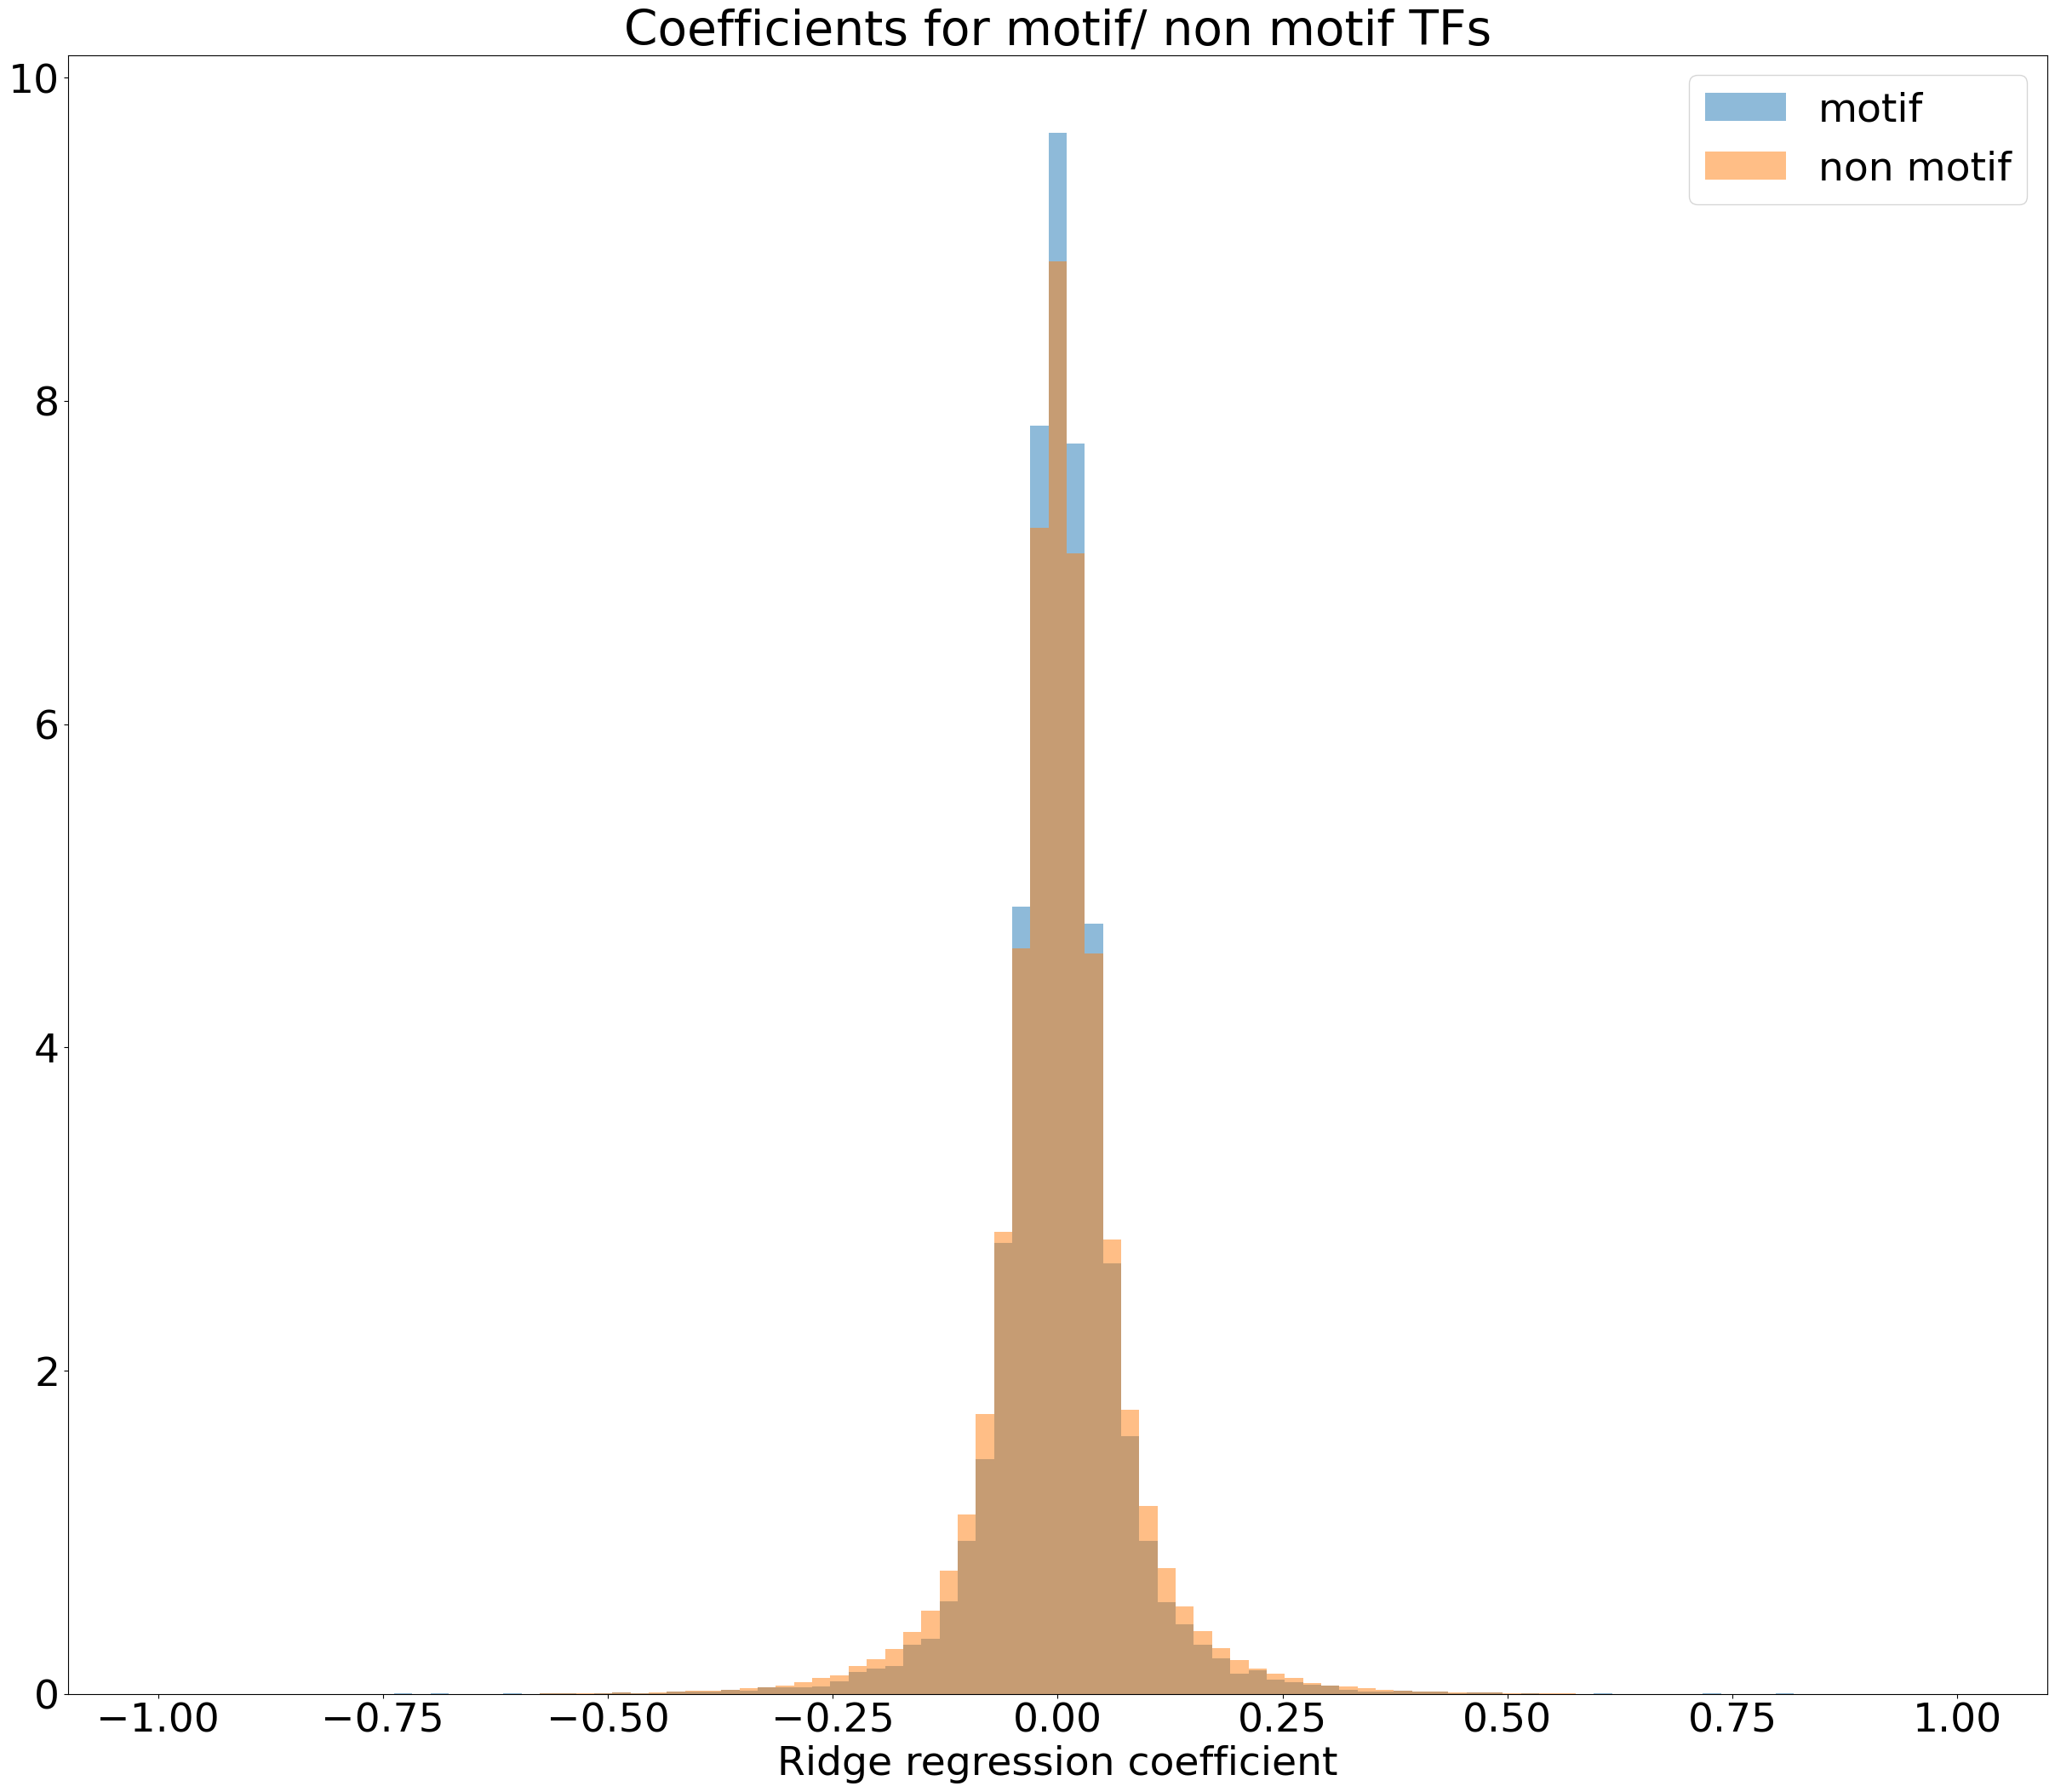

In [8]:
X = expression[list(transcription_factors_id)]
Y = expression[list(set(expression.columns) - set(transcription_factors_id))]

prior = []
others = []
for i in range(500): 
    reg = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X, Y.iloc[:, i])
    tfs = get_regulators_id(Y.columns[i])
    if len(tfs) == 0 : continue
    for j in range(len(reg.coef_)) :
        if X.columns[j] in tfs : 
            prior.append(reg.coef_[j])
        else :
            others.append(reg.coef_[j])
    if i % 50 == 0 :
        print(i)
plt.rcParams["figure.figsize"] = (30,25)
plt.rcParams.update({'font.size': 34})
bins = np.linspace(-1, 1, 100)

plt.hist(prior, bins, alpha=0.5, density = True, label='motif')
plt.hist(others, bins, alpha=0.5, density = True, label='non motif')
plt.legend(loc='upper right')
plt.title("Coefficients for motif/ non motif TFs")
plt.xlabel("Ridge regression coefficient")
plt.show()